# Dynamic depth warping

The algorithm is called ['dynamic time warping'](https://en.wikipedia.org/wiki/Dynamic_time_warping), but it actually doesn't care aobut the domain.

From the Wikipedia page, these are the rules of DTW:

- Every index from the first sequence must be matched with one or more indices from the other sequence, and vice versa.
- The first and last indices from the first sequence must be matched with the first and last indices respectively from the other sequence (but they does not have to be their only matches).
- The mapping of the indices from the first sequence to indices from the other sequence must be monotonically increasing, and vice versa.

There are several Python packages that implement DTW. 

## `fastdtw`

[`fastdtw`](https://github.com/slaypni/fastdtw) is 

> Python implementation of FastDTW [1], which is an approximate Dynamic Time Warping (DTW) algorithm that provides optimal or near-optimal alignments with an O(N) time and memory complexity.

[1] Stan Salvador, and Philip Chan. "FastDTW: Toward accurate dynamic time warping in linear time and space." Intelligent Data Analysis 11.5 (2007): 561-580.

To install the library:

    pip install fastdtw
    

In [3]:
import numpy as np

%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

## Toy example

First, 1D 'logs'...

In [4]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([3, 4, 4, 5])
distance, path = fastdtw(x, y, dist=euclidean)
print(path)

[(0, 0), (1, 0), (2, 0), (3, 1), (3, 2), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3)]


Also works with nD signals...

In [5]:
x = np.array([[1,2], [2,2], [3,4], [4,4.5], [5,5.6], [6,6]])
y = np.array([[2,2], [3,3], [4,6], [5,5]])
distance, path = fastdtw(x, y, dist=euclidean)
print(path)

[(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (5, 3)]


## Real data

Let's load a GR log and then try to correlate it with a stretched copy of part of itself.

In [6]:
import welly
w = welly.Well.from_las('data/F03-04.las')
gr = w.data['GR']

Header section Parameter regexp=~P was not found.


Resample to 5 m for speed and clarity...

In [7]:
gr_ = gr.to_basis(start=100, stop=3000, step=5)

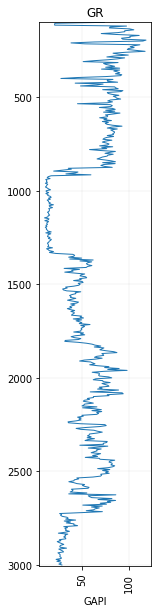

In [8]:
gr_.plot()

### Make a new log out of part of the GR log

We'll also add noise.

In [9]:
start, stop = 500, 2500

In [10]:
start_idx, stop_idx = gr_.read_at(start, index=True), gr_.read_at(stop, index=True)

In [11]:
snip = gr_.to_basis(start=start, stop=stop)
snip.step = 7
snip.start = 200.
snip_ = snip.copy()

# Comment out this line if you don't want to add noise:
snip_ = snip + np.convolve(np.ones(20), 4*(np.random.random(snip.size) - 0.5), mode='same')

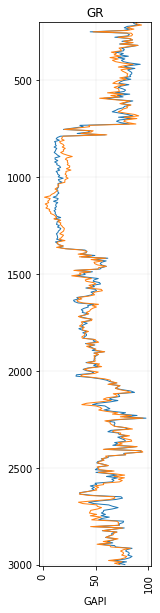

In [12]:
fig, ax = plt.subplots(figsize=(2,10))
ax = snip.plot(ax=ax)
ax = snip_.plot(ax=ax)
plt.show()

### Compute the DTW path

The `path` maps the indices of the first array to the indices of the second array.

WRT distance algos, I found the following:

- `lambda a, b: np.linalg.norm(a - b)` was about 3 s
- `scipy.spatial.distance.euclidean` was 7.3 s
- `scipy.spatial.distance.cosine` was 14.4 s

In [13]:
dist = lambda a, b: np.linalg.norm(a - b)

In [14]:
_, path = fastdtw(gr_, snip_, dist=dist)

In [15]:
path = np.array(path)
path

array([[  0,   0],
       [  1,   1],
       [  2,   1],
       ...,
       [578, 398],
       [579, 399],
       [580, 400]])

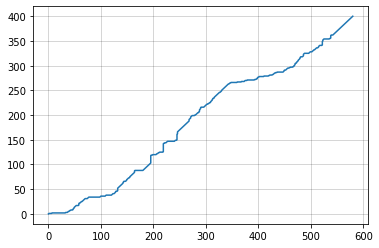

In [16]:
plt.plot(*path.T)
plt.grid(c='k', alpha=0.2)

### Compare the correlation

In [29]:
def compare(log1, log2, path, step=10, shift=500):
    fig, ax = plt.subplots(figsize=(4, 10))

    ax.plot(log1, log1.basis)
    ax.plot(log2+shift, log2.basis)
    ax.invert_yaxis()
    for a, b in path[::step]:
        plt.plot(*[(log1[a], log2[b]+shift), (log1.basis[a], log2.basis[b])], color=[0.75, 0.75, 0.75])
    plt.plot(*[(log1[start_idx], log2[start_idx]+shift), (log1.basis[start_idx], log2.basis[0])], lw=3, c='k')
    plt.plot(*[(log1[stop_idx], log2[-1]+shift), (log1.basis[stop_idx], log2.basis[-1])], lw=3, c='k')
    
    plt.show()
    return

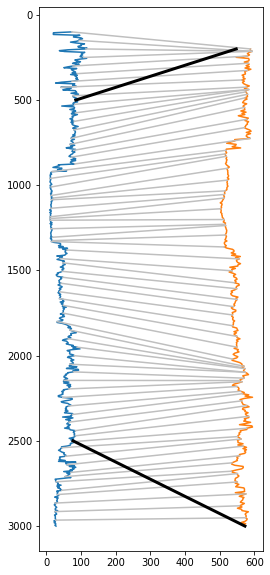

In [31]:
compare(gr_, snip_, path, step=10, shift=500)

## `pydtw`

Let's have a quick look at [`pydtw`](https://pypi.org/project/pydtw/) as well.

    pip install pydtw
    
According to Wikipedia, it

> implements the Manhattan and Euclidean flavoured DTW measures including the LB_Keogh lower bounds

In [25]:
from pydtw import dtw1d

cost_matrix, cost, alignmend_a, alignmend_b = dtw1d(gr_, snip_)

One nice thing &mdash; we get the cost matrix:

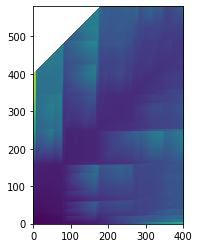

In [26]:
plt.imshow(cost_matrix, origin='lower')

Let's compare the path (orange) to what we got from `fastdtw` (blue):

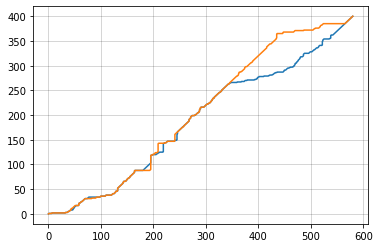

In [27]:
plt.plot(*path.T)
plt.plot(*np.array([alignmend_a, alignmend_b]))
plt.grid(c='k', alpha=0.2)

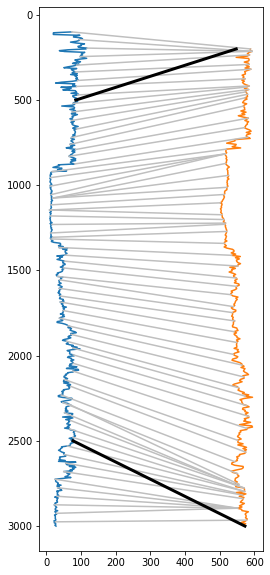

In [32]:
path = list(zip(alignmend_a, alignmend_b))
compare(gr_, snip_, path, step=10, shift=500)

It looks a bit better, IMO.